## Finetune QWEN2.5-VL-7B

### EN-Word

In [1]:
!nvidia-smi

Sat Sep 13 20:52:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti     On  |   00000000:02:00.0 Off |                  Off |
| 30%   24C    P8             35W /  480W |       2MiB /  24564MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # Automatically loads .env from the current directory

hf_token = os.getenv("HF_TOKEN")
roboflow_api_key = os.getenv("ROBOFLOW_API_KEY")

# Optional: Set them in os.environ if downstream libraries expect them there
os.environ["HF_TOKEN"] = hf_token
os.environ["ROBOFLOW_API_KEY"] = roboflow_api_key

## Data Prep

### Train data

In [ ]:
import pandas as pd
import os
import json
img_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_lower_20250513/labels_train.txt"
# all image names in image_path
image_folder = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_lower_20250513/images"
# get the list of all image names in the directory
img_list = os.listdir(image_folder)
print(f"Number of images in {image_folder}: {len(img_list)}")

img_csv = pd.read_csv(img_path, sep=",")
img_dict_train= {}
for index, row in img_csv.iterrows():
    if row['image_path'] in img_list:
        img_dict_train[row['image_path']] = (row['label'], 1) # dummy freq, we don't really need it for val and validation

with open("/swdata/yin/Cui/EM/reveil/data/en/en-word/lower/img_dict_train.json", "w", encoding="utf-8") as f:
    for key, value in img_dict_train.items():
        f.write(json.dumps({'image': key, 'prefix': 'Please identify the English words in the images', 'label': value[0], 'normal_freq': value[1]}, ensure_ascii=False) + "\n")

# print the img_dict
# print the first 10 items
for i, (key, value) in enumerate(img_dict_train.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

en_words_train = list(img_dict_train.keys())
len(en_words_train)

### Test Data

In [ ]:
# for test dataset, the img items are also stored in annotation file
annotation_path = "/swdata/yin/Cui/EM/reveil/data/en/en-word/word_freq.csv"
image_folder = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_lower_20250513/images"
# get the list of all image names in the directory
img_list = os.listdir(image_folder)
print(f"Number of images in {image_folder}: {len(img_list)}")

annotation_csv = pd.read_csv(annotation_path, sep=",")
img_dict_test= {}
for index, row in annotation_csv.iterrows():
    if row['image_path'] in img_list:
        img_dict_test[row['image_path']] = (row['label'], row['normal_freq'])

with open("/swdata/yin/Cui/EM/reveil/data/en/en-word/lower/img_dict_test.json", "w") as f:
    # dump to jsonl format
    for key, value in img_dict_test.items():
        f.write(json.dumps({'image': key, 'prefix': 'Please identify the English words in the images', 'label': value[0], 'normal_freq': value[1]}, ensure_ascii=False) + "\n")

for i, (key, value) in enumerate(img_dict_test.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

en_words_test = list(img_dict_test.keys())
len(en_words_test)

### Vali Data

In [ ]:
img_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_whole_20250513/labels_val.txt"
image_folder = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_whole_20250513/images"
img_list = os.listdir(image_folder)
print(f"Number of images in {image_folder}: {len(img_list)}")

img_csv = pd.read_csv(img_path, sep=",")
img_dict_val= {}
for index, row in img_csv.iterrows():
    if row['image_path'] in img_list:
        img_dict_val[row['image_path']] = (row['label'], 1) # dummy freq, we don't really need it for val and validation

with open("/swdata/yin/Cui/EM/reveil/data/en/en-word/whole/img_dict_val.json", "w", encoding="utf-8") as f:
    for key, value in img_dict_val.items():
        f.write(json.dumps({'image': key, 'prefix': 'Please identify the English words in the images', 'label': value[0], 'normal_freq': value[1]}, ensure_ascii=False) + "\n")

# print the img_dict
# print the first 10 items
for i, (key, value) in enumerate(img_dict_val.items()):
    if i == 5:
        break
    print(f"{key}: {value}")

en_words_val = list(img_dict_val.keys())
len(en_words_val)

### Format data for model

In [4]:
# image_directory_path = "/swdata/yin/Cui/EM/reveil/data/en/onestop/en_word_onestop_uniWords_newFont/whole/images"
# image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_whole_20250513/images"
# SYSTEM_MESSAGE = "You are a helpful assistant that can identify English words in images. You will be shown an image of a word, and you need to identify the word in the image. Please answer with a single word, and do not include any other text."
# PROMPT = "The image contains an English word. What is the word in the image? Please answer with a valid English word, and do not include any other text. The word is:"


# image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_upper_20250513/images"
# # image_directory_path = "/swdata/yin/Cui/EM/reveil/data/en/onestop/en_word_onestop_uniWords_newFont/upper/images"
# SYSTEM_MESSAGE = "You are a helpful assistant that can identify English words in images. The image will show only the upper half of an English word, with the lower half masked. Identify the word accurately based on the visible portion.  Please answer with a single word, and do not include any other text."
# PROMPT = "The image contains the upper half of an English word. The lower half is masked. What is the word in the image? Please answer with a single word, and do not include any other text. The word is:"


# image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_lower_20250513/images"
image_directory_path = "/swdata/yin/Cui/EM/reveil/data/en/onestop/en_word_onestop_uniWords_newFont/lower/images"
SYSTEM_MESSAGE = "You are a helpful assistant that can identify English words in images. The image will show only the lower half of an English word, with the upper half masked. Identify the word accurately based on the visible portion.  Please answer with a single word, and do not include any other text."
PROMPT = "The image contains the lower half of an English word. The upper half is masked. What is the word in the image? Please answer with a single word, and do not include any other text. The word is:"


def format_data(image_directory_path, entry):
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": SYSTEM_MESSAGE}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_directory_path + "/" + entry['image'],
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": entry['label']}],
        },
    ]


In [5]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset

class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        # print(entries )
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry, format_data(self.image_directory_path, entry)

In [6]:
# train_dataset = JSONLDataset(
#     jsonl_file_path="/swdata/yin/Cui/EM/reveil/data/zh/zh-char/upper/img_dict_train.json",
#     image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_upper_20250512/images",
# )
# valid_dataset = JSONLDataset(
#     jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/zh/zh-char/upper/img_dict_val.json",
#     image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_zh/zh_char_upper_20250512/images",
# )

# test_dataset = JSONLDataset(
#     jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/en/en-word/whole/img_dict_test.json",
#     image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_whole_20250513/images",
# )

# test_dataset = JSONLDataset(
#     jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/en/en-word/upper/img_dict_test.json",
#     image_directory_path = "/swdata/yin/Cui/Re-Veil/create-dataset-new/dataset_en/en_word_upper_20250513/images",
# )

test_dataset = JSONLDataset(
    jsonl_file_path = "/swdata/yin/Cui/EM/reveil/data/en/onestop/en_word_onestop_uniWords_newFont/lower/img_dict_test.json",
    image_directory_path = "/swdata/yin/Cui/EM/reveil/data/en/onestop/en_word_onestop_uniWords_newFont/lower/images",
)


In [ ]:
# test_dataset = [test_dataset[i] for i in range(100)]

In [7]:
test_dataset[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=95x50>,
 {'image': '0.jpg',
  'prefix': 'Please identify the English words in the images',
  'label': 'Year',
  'normal_freq': 0.0012620344886189},
 [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a helpful assistant that can identify English words in images. The image will show only the lower half of an English word, with the upper half masked. Identify the word accurately based on the visible portion.  Please answer with a single word, and do not include any other text.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': '/swdata/yin/Cui/EM/reveil/data/en/onestop/en_word_onestop_uniWords_newFont/lower/images/0.jpg'},
    {'type': 'text',
     'text': 'The image contains the lower half of an English word. The upper half is masked. What is the word in the image? Please answer with a single word, and do not include any other text. The word is:'}]},
  {'role': 'assistant', 'content': [{'t

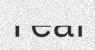

In [8]:
test_dataset[0][0]

## Zero-Shot Qwen2.5-VL-7b

In [9]:
from maestro.trainer.models.qwen_2_5_vl.checkpoints import load_model, OptimizationStrategy

MODEL_ID_OR_PATH = "Qwen/Qwen2.5-VL-7B-Instruct"
# MODEL_ID_OR_PATH = "Qwen/Qwen2.5-VL-72B-Instruct"
MIN_PIXELS = 28 * 28
MAX_PIXELS = 1028 * 28 * 28

/swdata/yin/miniconda3/envs/reveil/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
processor, model = load_model(
    model_id_or_path=MODEL_ID_OR_PATH,
    optimization_strategy=OptimizationStrategy.NONE,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 5/5 [02:49<00:00, 33.80s/it]


In [11]:
import torch
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor

from maestro.trainer.common.utils.device import parse_device_spec
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation

def predict_score_with_inputs(
    model: Qwen2_5_VLForConditionalGeneration,
    processor: Qwen2_5_VLProcessor,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    pixel_values: torch.Tensor,
    image_grid_thw: torch.Tensor,
    device: torch.device,
    max_new_tokens: int = 1024,
) -> list[str]:
    """
    Generates predictions from the Qwen2.5-VL model using both textual and visual inputs.

    Args:
        model (Qwen2_5_VLForConditionalGeneration):
            A Qwen2.5-VL model capable of conditional text generation with visual context.
        processor (Qwen2_5_VLProcessor):
            Preprocessing and postprocessing utility for the Qwen2.5-VL model.
        input_ids (torch.Tensor):
            Tokenized input text IDs.
        attention_mask (torch.Tensor):
            Attention mask corresponding to the tokenized input.
        pixel_values (torch.Tensor):
            Preprocessed image data (pixel values) for visual inputs.
        image_grid_thw (torch.Tensor):
            Tensor specifying the layout or shape of the provided images.
        device (torch.device):
            Device on which to run inference (e.g., ``torch.device("cuda")`` or ``torch.device("cpu")``).
        max_new_tokens (int):
            Maximum number of tokens to generate.

    Returns:
        list[str]: A list of decoded strings corresponding to the generated sequences.
    """
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            pixel_values=pixel_values.to(device),
            image_grid_thw=image_grid_thw.to(device),
            max_new_tokens=max_new_tokens,
            output_scores=True,
            return_dict_in_generate=True,
            do_sample=False,  # Non-greedy decoding
        )
        generated_ids = [
            generated_sequence[len(input_sequence) :]
            for input_sequence, generated_sequence in zip(input_ids, outputs.sequences)
        ]
        return processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False), outputs.scores

In [12]:
from PIL import Image
from typing import Optional, Tuple, Union
import numpy as np
import json

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info
import torch
import torch.nn.functional as F

def run_qwen_2_5_vl_inference(
    model,
    processor,
    conversation: Union[str, dict],
    target_token: str = "a",
    device: str = "auto",
    max_new_tokens: int = 1024,
) -> Tuple[str, Tuple[int, int]]:
    device = parse_device_spec(device)
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=text,
        images=image_inputs,
        return_tensors="pt",
    )
    responses, scores = predict_score_with_inputs(
        **inputs,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=max_new_tokens
    )
    response = responses[0]

    logits = scores[0][0]
    probs = F.softmax(logits, dim=-1)
    target_token_tokenized = processor.tokenizer.tokenize(target_token) 
    target_token_id = processor.tokenizer.convert_tokens_to_ids(target_token_tokenized[0])  # a few target tokens will have multiple subtokens
    prob_target = probs[target_token_id].item()

    # Entropy of the distribution
    entropy = -(probs * probs.log()).sum().item()

    # Top-5 predictions with probabilities and logits
    topk_probs, topk_ids = torch.topk(probs, k=5)
    topk_tokens = [processor.tokenizer.decode([idx]).strip() for idx in topk_ids]
    top5 = [
        {"token": tok, "prob": prob.item(), "logit": logits[idx].item()}
        for tok, prob, idx in zip(topk_tokens, topk_probs, topk_ids)
    ]

    return {
        "response": response,
        "target": target_token,
        "prob_target": prob_target,
        "entropy": entropy,
        "top5": top5
    }



In [ ]:
import csv
ent = 0.0
acc = 0.0
cross_ent = 0.0
results = []
csv_rows = []
json_path = "/swdata/yin/Cui/EM/reveil/precomputed/EN/words/onestop/lower/zero_shot_en_word_lower.json"
csv_path = "/swdata/yin/Cui/EM/reveil/precomputed/EN/words/onestop/lower/zero_shot_en_word_lower.csv"

for image, entry, conversations in test_dataset:
    image_id = entry['image']
    conversation = conversations[:2]
    target = entry['label']
    freq = entry['normal_freq']

    result = run_qwen_2_5_vl_inference(model=model, processor=processor, conversation = conversation, target_token=target, device="cuda", max_new_tokens=1024)
    response = result['response']
    prob_target = result['prob_target']
    entropy = result['entropy']
    surp = -np.log(prob_target)
    accuracy = int(response.strip() == target.strip())

    print(f"Target_Char: {target}, Response: {result['response']}")

    ent +=  entropy
    # cross entropy is the negative log likelihood of the target token
    cross_ent += surp
    print(f"Entropy: {result['entropy']:.4f}, Cumulative Entropy: {ent:.4f}, Surprisal: {surp:.4f}")
    
    # check accuracy
    acc += accuracy

    results.append(result)

    csv_rows.append([
        image_id, target, freq, entropy, surp, prob_target, response, accuracy
    ])

with open(json_path, "w") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "image_id", "target", "freq", "entropy", "surprisal", "prob_target", "response", "acc"
    ])
    writer.writerows(csv_rows)

print(f"Entropy: {ent / len(test_dataset):.4f}")
print(f"Cross Entropy: {cross_ent / len(test_dataset):.4f}")
print(f"Recognition Accuracy: {acc / len(test_dataset):.4f}")

Target_Char: Year, Response: real
Entropy: 1.3188, Cumulative Entropy: 1.3188, Surprisal: 9.0606
Target_Char: Old, Response: old
Entropy: 2.2572, Cumulative Entropy: 3.5760, Surprisal: 1.0350
Target_Char: Bottle, Response: Doll
Entropy: 4.7398, Cumulative Entropy: 8.3158, Surprisal: 1.7658
Target_Char: Message, Response: Message
Entropy: 1.4914, Cumulative Entropy: 9.8071, Surprisal: 0.6506
Target_Char: Angela, Response: Anglia
Entropy: 5.4341, Cumulative Entropy: 15.2412, Surprisal: 1.2897
Target_Char: Erdmann, Response: Library
Entropy: 5.5894, Cumulative Entropy: 20.8306, Surprisal: 5.3435
Target_Char: never, Response: level
Entropy: 5.8906, Cumulative Entropy: 26.7212, Surprisal: 3.6296
Target_Char: knew, Response: know
Entropy: 3.0663, Cumulative Entropy: 29.7874, Surprisal: 1.9262
Target_Char: her, Response: HAT
Entropy: 6.8225, Cumulative Entropy: 36.6100, Surprisal: 7.8168
Target_Char: grandfather, Response: grandfather
Entropy: 2.7861, Cumulative Entropy: 39.3960, Surprisal: 0

In [15]:
sum = 0
for entry in results:
    entropy = entry['entropy']
    sum += entropy
print(f"Average Entropy: {sum / len(results):.4f}")



Average Entropy: 3.2567


### Unconditional Entropy

In [ ]:
def entropy(freqs):
    total = sum(freqs)
    if total == 0:
        return 0
    return -sum((f / total) * np.log(f / total) for f in freqs if f > 0)
# print("Entropy of letters:", entropy([english_letter_freq[letter] for letter in english_letter_freq.keys()]))
print("Unconditional Entropy:", entropy([test_item[1]['normal_freq'] for test_item in test_dataset]))

# Fine Tuned Model

## Model Load

In [ ]:
import torch

from peft import get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor

MIN_PIXELS = 28 * 28
MAX_PIXELS = 1280 * 28 * 28

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "models/qwen2.5-7b-instruct-reveil-en-word-lower/best",
    device_map="cuda",
    torch_dtype=torch.bfloat16
)

processor = Qwen2_5_VLProcessor.from_pretrained(
    "models/qwen2.5-7b-instruct-reveil-en-word-lower/best",
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS
)



In [ ]:
import torch
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor

from maestro.trainer.common.utils.device import parse_device_spec
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation

def predict_score_with_inputs(
    model: Qwen2_5_VLForConditionalGeneration,
    processor: Qwen2_5_VLProcessor,
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    pixel_values: torch.Tensor,
    image_grid_thw: torch.Tensor,
    device: torch.device,
    max_new_tokens: int = 1024,
) -> list[str]:
    """
    Generates predictions from the Qwen2.5-VL model using both textual and visual inputs.

    Args:
        model (Qwen2_5_VLForConditionalGeneration):
            A Qwen2.5-VL model capable of conditional text generation with visual context.
        processor (Qwen2_5_VLProcessor):
            Preprocessing and postprocessing utility for the Qwen2.5-VL model.
        input_ids (torch.Tensor):
            Tokenized input text IDs.
        attention_mask (torch.Tensor):
            Attention mask corresponding to the tokenized input.
        pixel_values (torch.Tensor):
            Preprocessed image data (pixel values) for visual inputs.
        image_grid_thw (torch.Tensor):
            Tensor specifying the layout or shape of the provided images.
        device (torch.device):
            Device on which to run inference (e.g., ``torch.device("cuda")`` or ``torch.device("cpu")``).
        max_new_tokens (int):
            Maximum number of tokens to generate.

    Returns:
        list[str]: A list of decoded strings corresponding to the generated sequences.
    """
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            pixel_values=pixel_values.to(device),
            image_grid_thw=image_grid_thw.to(device),
            max_new_tokens=max_new_tokens,
            output_scores=True,
            return_dict_in_generate=True,
            do_sample=False,  # Non-greedy decoding
        )
        generated_ids = [
            generated_sequence[len(input_sequence) :]
            for input_sequence, generated_sequence in zip(input_ids, outputs.sequences)
        ]
        return processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False), outputs.scores

In [ ]:
from PIL import Image
from typing import Optional, Tuple, Union
import numpy as np
import json

from maestro.trainer.models.qwen_2_5_vl.inference import predict_with_inputs
from maestro.trainer.models.qwen_2_5_vl.loaders import format_conversation
from maestro.trainer.common.utils.device import parse_device_spec
from qwen_vl_utils import process_vision_info
import torch
import torch.nn.functional as F

def run_qwen_2_5_vl_inference(
    model,
    processor,
    conversation: Union[str, dict],
    target_token: str = "a",
    device: str = "auto",
    max_new_tokens: int = 1024,
) -> Tuple[str, Tuple[int, int]]:
    device = parse_device_spec(device)
    text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(conversation)

    inputs = processor(
        text=text,
        images=image_inputs,
        return_tensors="pt",
    )
    responses, scores = predict_score_with_inputs(
        **inputs,
        model=model,
        processor=processor,
        device=device,
        max_new_tokens=max_new_tokens
    )
    response = responses[0]

    logits = scores[0][0]
    probs = F.softmax(logits, dim=-1)
    target_token_tokenized = processor.tokenizer.tokenize(target_token) 
    target_token_id = processor.tokenizer.convert_tokens_to_ids(target_token_tokenized[0])  # a few target tokens will have multiple subtokens
    prob_target = probs[target_token_id].item()

    # Entropy of the distribution
    entropy = -(probs * probs.log()).sum().item()

    # Top-5 predictions with probabilities and logits
    topk_probs, topk_ids = torch.topk(probs, k=5)
    topk_tokens = [processor.tokenizer.decode([idx]).strip() for idx in topk_ids]
    top5 = [
        {"token": tok, "prob": prob.item(), "logit": logits[idx].item()}
        for tok, prob, idx in zip(topk_tokens, topk_probs, topk_ids)
    ]

    return {
        "response": response,
        "target": target_token,
        "prob_target": prob_target,
        "entropy": entropy,
        "top5": top5
    }



In [ ]:
import csv
import string
ent = 0.0
acc = 0.0
cross_ent = 0.0
results = []
csv_rows = []
json_path = "/swdata/yin/Cui/EM/reveil/precomputed/EN/words/onestop/lower/finetune_en_word_lower_best.json"
csv_path = "/swdata/yin/Cui/EM/reveil/precomputed/EN/words/onestop/lower/finetune_en_word_lower_best.csv"

for image, entry, conversations in test_dataset:
    image_id = entry['image']
    conversation = conversations[:2]
    target = entry['label']
    freq = entry['normal_freq']

    result = run_qwen_2_5_vl_inference(model=model, processor=processor, conversation = conversation, target_token=target, device="cuda", max_new_tokens=3)
    response = result['response'].split(' ')[0]   # sometime, it prodocue multiple tokens.
    response = response.translate(str.maketrans('', '', string.punctuation)).strip()
    prob_target = result['prob_target']
    entropy = result['entropy']
    surp = -np.log(prob_target)
    accuracy = int(response.strip() == target.strip())

    # print(f"Target_Char: {target}, Response: {result['response']}")

    ent +=  entropy
    # cross entropy is the negative log likelihood of the target token
    cross_ent += surp
    # print(f"Entropy: {result['entropy']:.4f}, Cumulative Entropy: {ent:.4f}, Surprisal: {surp:.4f}")
    if accuracy == 0:
        print(f"Target_Char: {target}, Response: {result['response']}")
        print(f"Entropy: {result['entropy']:.4f}, Cumulative Entropy: {ent:.4f}, Surprisal: {surp:.4f}")
    
    # check accuracy
    acc += accuracy

    results.append(result)

    csv_rows.append([
        image_id, target, freq, entropy, surp, prob_target, response, accuracy
    ])

with open(json_path, "w") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "image_id", "target", "freq", "entropy", "surprisal", "prob_target", "response", "acc"
    ])
    writer.writerows(csv_rows)

print(f"Entropy: {ent / len(test_dataset):.4f}")
print(f"Cross Entropy: {cross_ent / len(test_dataset):.4f}")
print(f"Recognition Accuracy: {acc / len(test_dataset):.4f}")